In [2]:
rm(list = ls())
options(stringsAsFactors = F)
gc()
library(glmnet)
library(survival)
library(survivalROC)
library(survminer)
library(timeROC)
library("clusterProfiler")
library("org.Hs.eg.db")
library("enrichplot")
library("ggplot2")
library(plyr)
library(ggplot2)
library(grid)
library(gridExtra)
pvalueFilter=0.05      
qvalueFilter=0.05 
source('./00.data/fun.R',print.eval = TRUE)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,5353043,285.9,8642171,461.6,6568210,350.8
Vcells,8910164,68.0,15122512,115.4,10379523,79.2


In [3]:
input <- './fig4/05.model/cox_input.txt'
rt <- read.table(input,header = T,row.names = 1,check.names = F,sep = '\t')

# univariate analysis

In [4]:
surSigExp <- Processing_2(rt)
surSigExp  <- as.data.frame(t(as.data.frame(surSigExp, check.names = FALSE)))
write.table(surSigExp, file = paste('./fig4/05.model/','LIHC', "_uni_cox_os.txt",sep=""), sep = "\t", quote = F, row.names = T)
res_results_0.05 <- na.omit(surSigExp[which(as.numeric(surSigExp$p.value) < 0.05),])
write.table(res_results_0.05, file = paste('./fig4/05.model/','LIHC', "_uni_cox_os_sig.txt",sep=""), sep = "\t", quote = F, row.names = T)

# lasso analysis

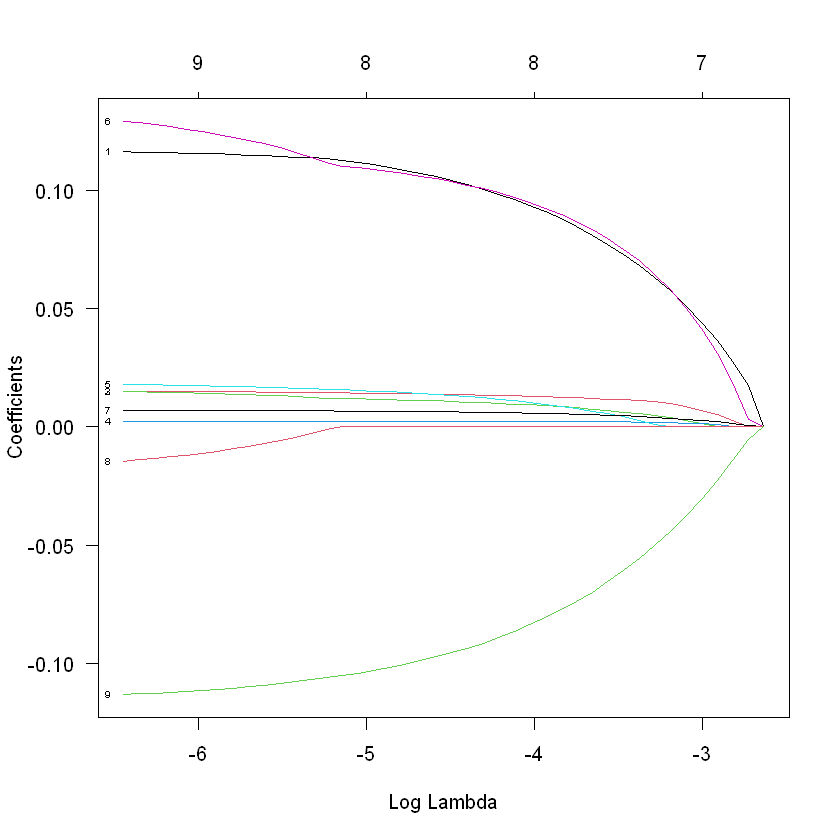

In [5]:
x_all <- subset(rt, select = -c(futime,fustat))
  x <- x_all[,rownames(res_results_0.05)]
  y <- subset(rt, select = c(futime,fustat))
  fit <- glmnet(as.matrix(x), Surv(y$futime,y$fustat), 
                family = "cox") 
  plot(fit, xvar = "lambda",label = TRUE, las=1)

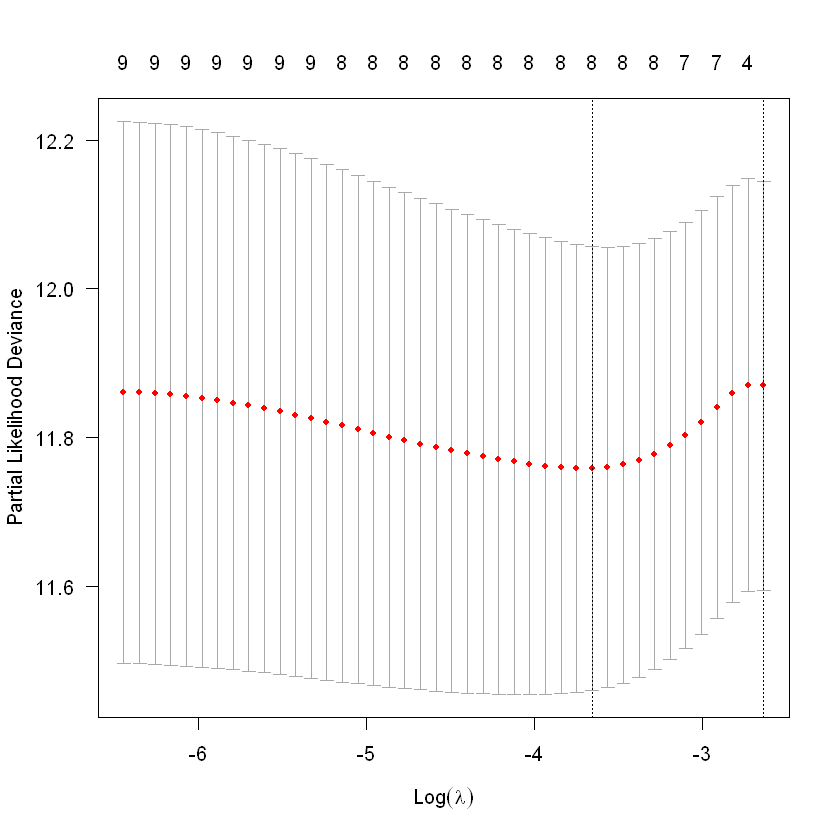

In [6]:
set.seed(123)
  cvfit = cv.glmnet(as.matrix(x),
                    Surv(y$futime,y$fustat),
                    nfold=10,
                    family = "cox") 
  plot(cvfit, las =1)

In [8]:
coef.min = coef(cvfit, s = cvfit$lambda.min)
  cvfit$lambda.min
  df.coef = cbind(gene = rownames(coef.min), coefficient = coef.min[,1]) %>% as.data.frame()
  df.coef = subset(df.coef, coefficient != 0) %>% as.data.frame
  write.table(df.coef, "./fig4/05.model/Lasso_Coefficients.xls", sep = "\t", quote = F, col.names = T, row.names = F)
  index=which(coef.min != 0)
  actCoef=coef.min[index]
  myFun=function(x){crossprod(as.numeric(x),actCoef)}
  x2 <- x[,index]
  riskScore=apply(x2,1,myFun)
  risk_data <- rt[,c('futime','fustat',rownames(df.coef))]
  risk_data$riskScore <- riskScore
  rt <-risk_data
  outTab=rbind(geneNames=colnames(rt ),rt)
  write.table(outTab, file="./fig4/05.model/train_riskScore.txt", sep="\t", quote=F, col.names=F)

[1] 0.02585495

## Calculate the Optimal cut-off value for 3 years

In [9]:
predictTime=3      
roc=survivalROC(Stime=rt$futime, status=rt$fustat, marker = rt$riskScore, predict.time =predictTime, method="KM")
sum=roc$TP-roc$FP
cutOp=roc$cut.values[which.max(sum)]
cutTP=roc$TP[which.max(sum)]
cutFP=roc$FP[which.max(sum)]

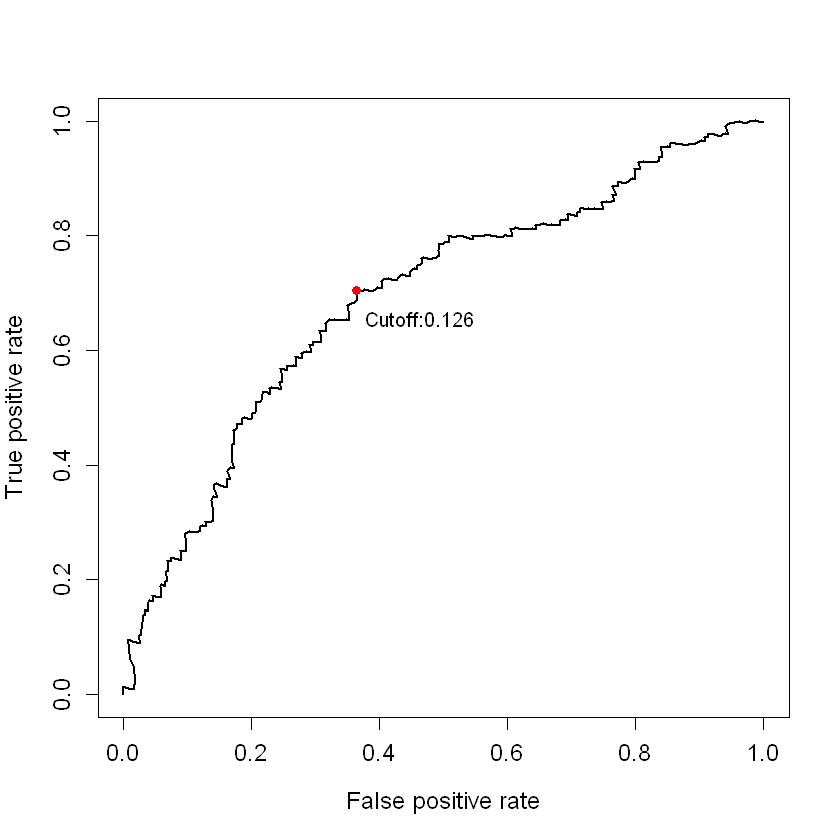

In [10]:
plot(roc$FP, roc$TP, type="l", xlim=c(0,1), ylim=c(0,1),col="black", 
     xlab="False positive rate", ylab="True positive rate",
     lwd = 2, cex.main=1.2, cex.lab=1.2, cex.axis=1.2, font=1.2)
points(cutFP,cutTP, pch=20, col="red",cex=1.5)
text(cutFP+0.1,cutTP-0.05,paste0("Cutoff:",sprintf("%0.3f",cutOp)))

## survial train set

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Windows字体数据库里没有这样的字体系列"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Windows字体数据库里没有这样的字体系列"


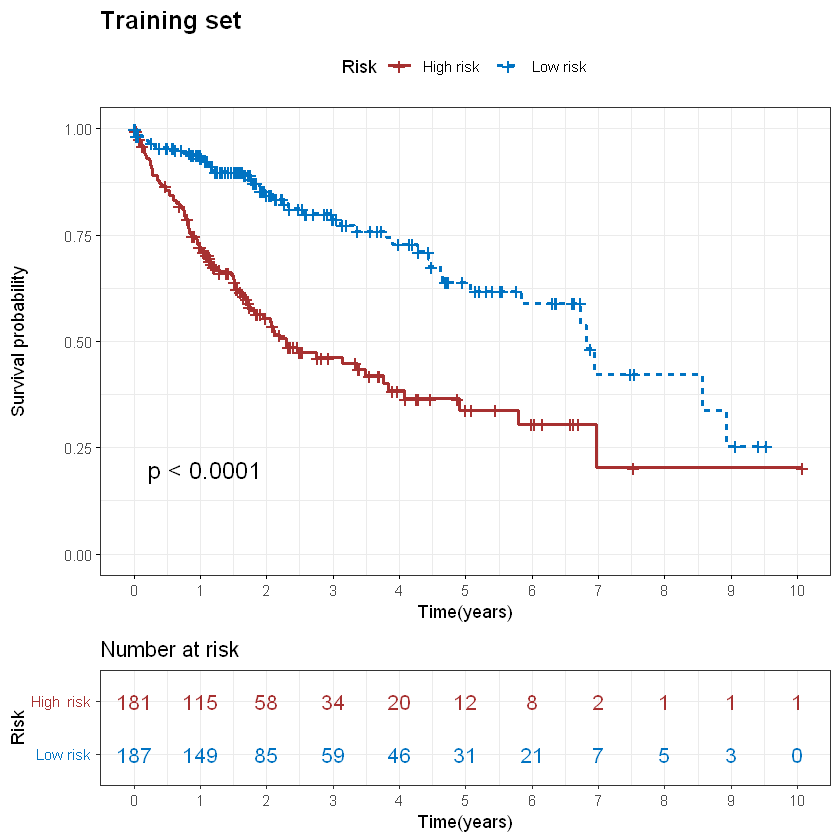

In [11]:
surPlot <- survial_plot(rt)
print(surPlot)

## AUC

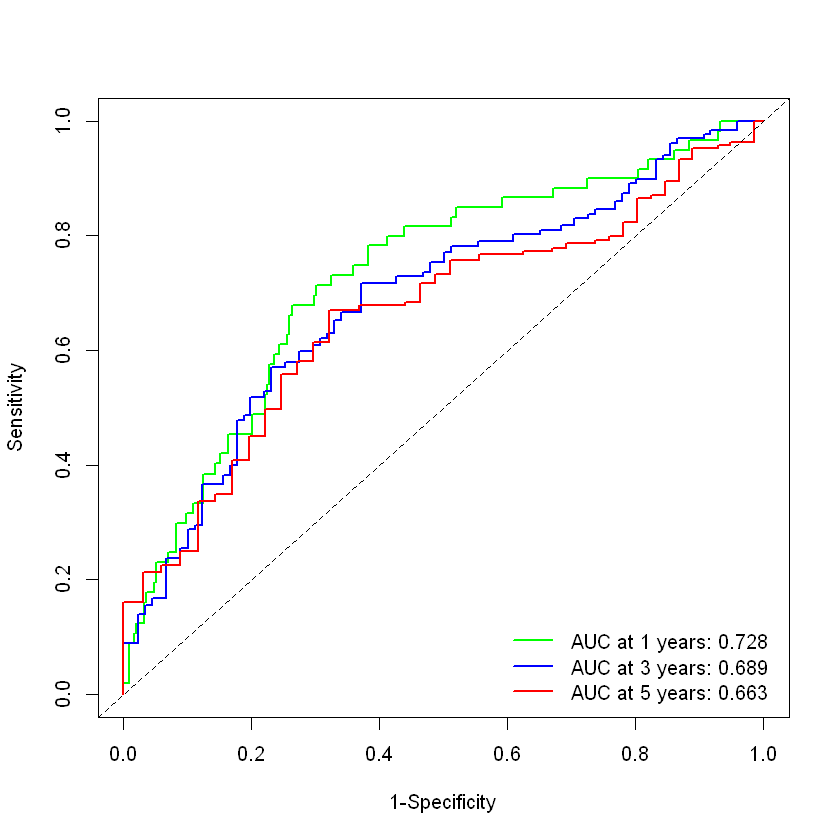

In [12]:
var = 'riskScore'
ROC_rt=timeROC(T=rt$futime, delta=rt$fustat,
               marker=rt[,var], cause=1,
               weighting='aalen',
               times=c(1,3,5), ROC=TRUE)
plot(ROC_rt,time=1,col='green',title=FALSE,lwd=2)
plot(ROC_rt,time=3,col='blue',add=TRUE,title=FALSE,lwd=2)
plot(ROC_rt,time=5,col='red',add=TRUE,title=FALSE,lwd=2)
legend('bottomright',
       c(paste0('AUC at 1 years: ',sprintf("%.03f",ROC_rt$AUC[1])),
         paste0('AUC at 3 years: ',sprintf("%.03f",ROC_rt$AUC[2])),
         paste0('AUC at 5 years: ',sprintf("%.03f",ROC_rt$AUC[3]))),
       col=c("green",'blue','red'),lwd=2,bty = 'n')

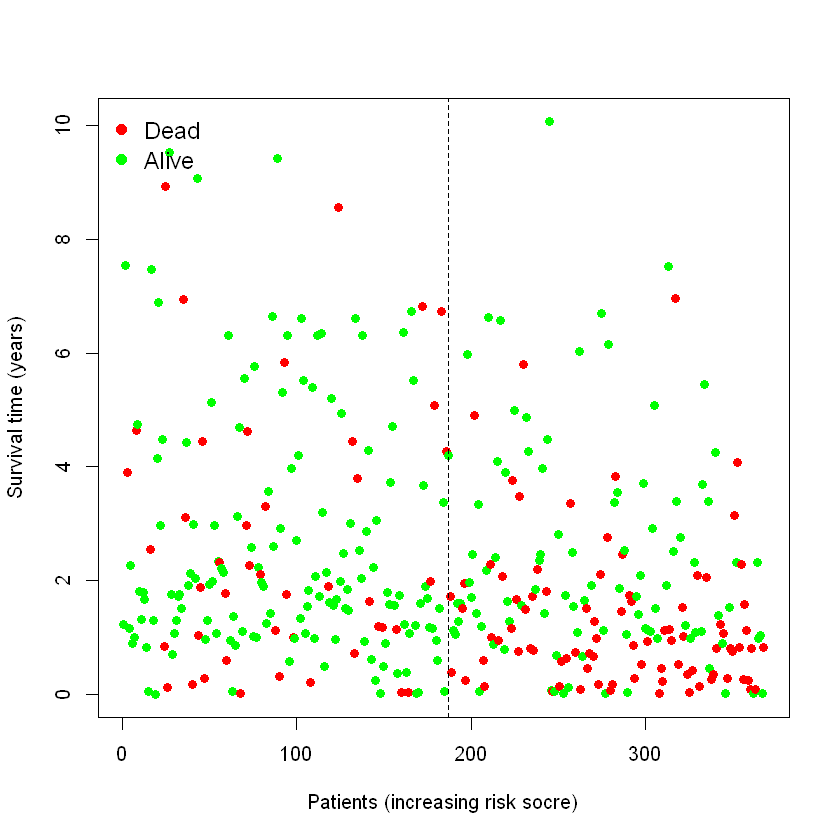

In [13]:
rt$risk <- as.vector(ifelse(rt$riskScore>cutOp,"High", "Low"))
rt=rt[order(rt$riskScore),]
  riskClass=rt[,"risk"]
  lowLength=length(riskClass[riskClass=="Low"])
  highLength=length(riskClass[riskClass=="High"])
  color=as.vector(rt$fustat)
  color[color==1]="red"
  color[color==0]="green"
plot(rt$futime,
       pch=19,
       xlab="Patients (increasing risk socre)",
       ylab="Survival time (years)",
       col=color)
  legend("topleft", c("Dead", "Alive"),bty="n",pch=19,col=c("red","green"),cex=1.2)
  abline(v=lowLength,lty=2)

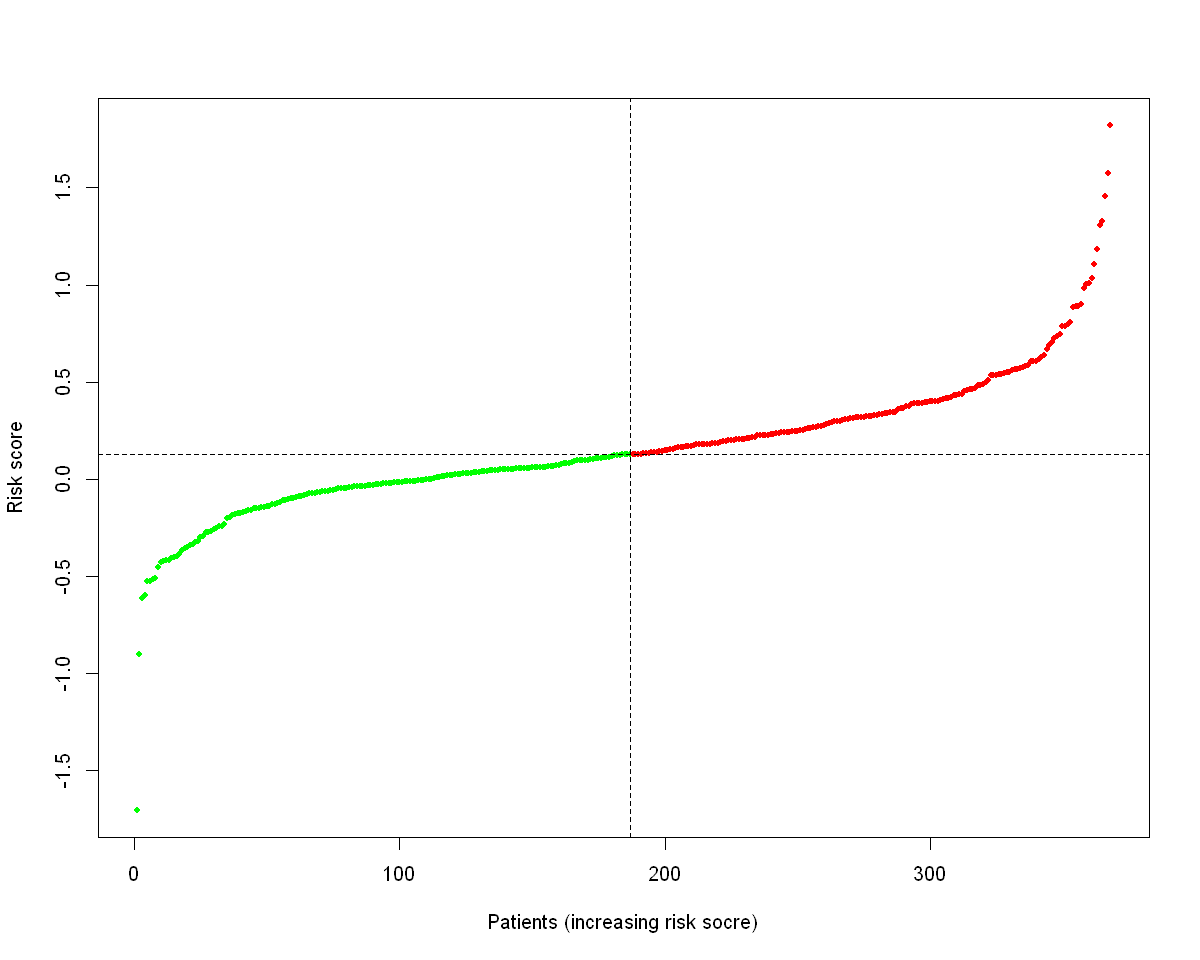

In [36]:
rt=rt[order(rt$riskScore),]
  riskClass=rt[,"risk"]
  lowLength=length(riskClass[riskClass=="Low"])
  highLength=length(riskClass[riskClass=="High"])
  line=rt[,"riskScore"]
  line[line>10]=10
  plot(line,
       type="p",
       pch=20,
       xlab="Patients (increasing risk socre)",
       ylab="Risk score",
       col=c(rep("green",lowLength),
             rep("red",highLength)))
  trainMedianScore=cutOp
  abline(h=trainMedianScore,v=lowLength,lty=2)

## GSEA

In [15]:
dir <- './fig4/GSEA/'
files=grep(".tsv", dir('./fig4/GSEA/'), value=T) #获取目录下的所有tsv文件
x <- "High Risk<----------->Low Risk"
pGsea=gseaplot1(dir=dir,files=files,x=x)
pGene=gseaplot2(dir=dir,files=files,x=x)

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."


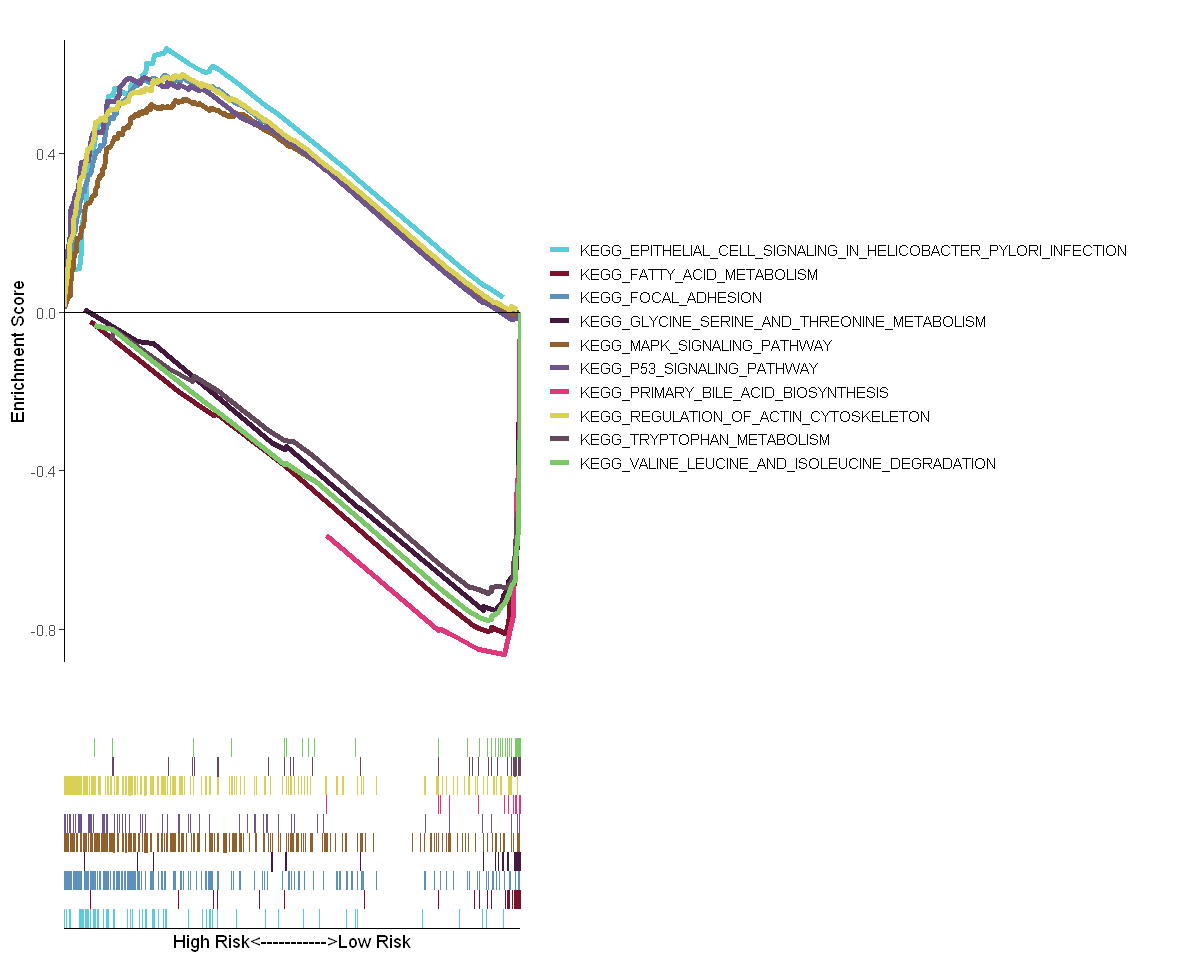

In [16]:
gGsea = ggplot_gtable(ggplot_build(pGsea))
gGene = ggplot_gtable(ggplot_build(pGene))
maxWidth = grid::unit.pmax(gGsea$widths, gGene$widths)
gGsea$widths = as.list(maxWidth)
gGene$widths = as.list(maxWidth)
options(repr.plot.width = 10, repr.plot.height = 8)
par(mar=c(5,5,2,5))
grid.arrange(arrangeGrob(gGsea,gGene,nrow=2,heights=c(.8,.3)))

In [35]:
test <- read.table('./fig5/test-input.txt',header = T,row.names = 1,check.names = F,sep = '\t')
test1 <-test[,colnames(x2)]
riskScore_test=apply(test1,1,myFun)
test$riskScore <- riskScore_test
test$risk <- as.vector(ifelse(test$riskScore>cutOp,"High", "Low"))
test[1:10,1:13]
outTab=rbind(id=colnames(test), test)
write.table(outTab, file='./fig5/testRisk.txt', sep="\t", quote=F, col.names=F)

,futime,fustat,PDLIM3,PAM,PDLIM7,FSCN1,DPYSL2,ARID5B,LGALS3,KLF2,CSPG4,riskScore,risk
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
GSM2011285,2.56,0,29.63191,19.25566,16.46247,16.45543,19.96926,22.29122,19.12970,19.685131,40.013424,3.5128820,High
GSM2011286,2.17,0,31.66783,20.17925,17.14568,17.15932,20.68133,21.76854,21.07947,79.033232,8.312303,-0.4829233,Low
GSM2011287,0.04,0,32.06947,22.55999,16.23894,17.10236,21.27915,22.00903,23.22663,75.611505,2.654464,-0.1541891,Low
GSM2011288,0.49,1,30.39694,20.53873,17.66054,16.75321,22.12047,22.01510,23.34640,83.228127,14.290891,-0.8302920,Low
GSM2011289,0.98,1,30.81337,20.28713,16.84061,17.09225,21.37543,22.09936,19.90121,116.177527,53.777526,-3.1245590,Low
GSM2011290,0.03,0,30.05775,20.66965,16.27868,17.03023,20.56908,42.36067,19.98660,1.956645,73.900070,6.4878569,High
GSM2011291,0.58,0,32.29651,22.25367,19.23687,19.85480,22.84944,23.60799,23.93334,82.767399,7.980190,-0.4636220,Low
GSM2011292,0.04,0,29.91153,20.94320,16.58932,17.88816,21.45377,21.80534,22.55440,5.642649,51.586818,4.5289300,High
GSM2011293,1.80,0,30.49446,18.52063,16.35184,14.91299,18.34446,20.62265,20.58535,94.035092,30.497276,-1.7719245,Low


In [37]:
cutOp

[1] 0.1262358